In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
import sklearn as skl


import tensorflow as tf
import imghdr
import cv2

import warnings
warnings.filterwarnings('ignore')


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

<font size = '+20'> <b> Removing corrupted images </b> </font>

In [4]:
import filter

for img_class in os.listdir('data'):
    for image in os.listdir('data\\' + img_class):
        image_path = 'data\\' + img_class + '\\' + image
        image = filter.JPEG(image_path) 
        try:
            image.decode()   
        except:
            print("INVALID_DATA!")
            os.remove(image_path)

<font size = "+20"> <b> Loading Data </b> </font>

In [5]:
data = tf._keras.utils.image_dataset_from_directory('data', shuffle = True,image_size = (256,256))

Found 42532 files belonging to 2 classes.


In [6]:
data_iterator = data.as_numpy_iterator()

In [7]:
batch = data_iterator.next()

In [8]:
print(batch[0].shape)
print(batch[1])

(32, 256, 256, 3)
[0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1]


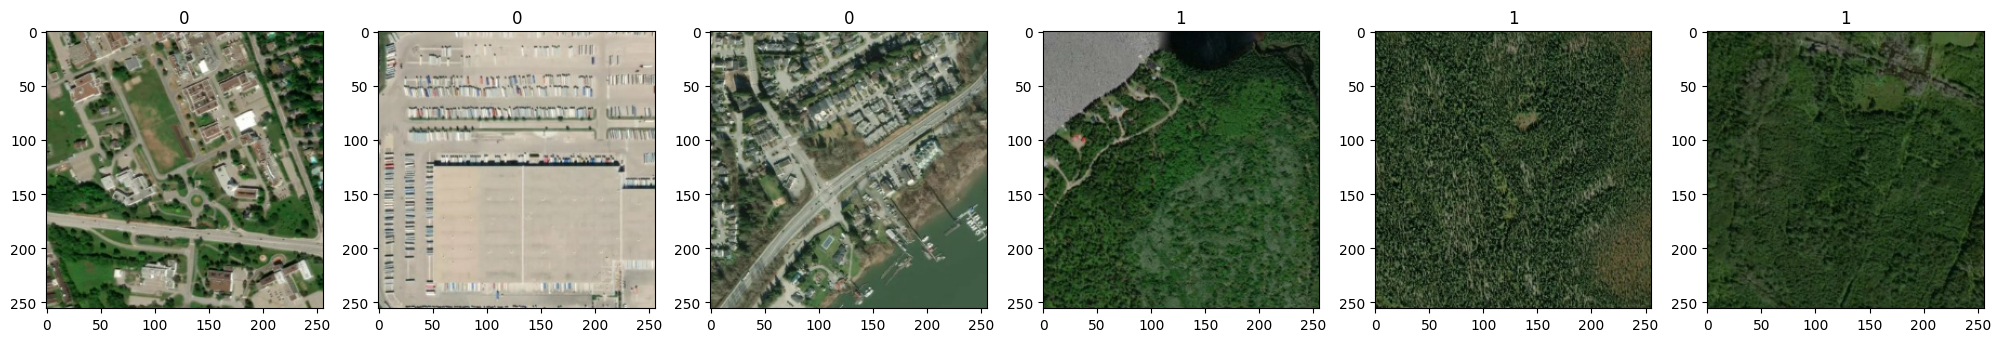

In [9]:
fig, ax = plt.subplots(ncols = 6, figsize = (25,25))
for i,image in enumerate(batch[0][:6]):
    ax[i].imshow(image.astype(int))
    ax[i].title.set_text(batch[1][i])

<font size = "+3"> <b> so class 1 for wildfire and class 0 for nowildfire </font> </b> 

In [10]:
batch[0]

array([[[[111.58493   , 122.21774   ,  92.40134   ],
         [152.5017    , 159.84935   , 132.5017    ],
         [174.67249   , 177.00061   , 152.83655   ],
         ...,
         [ 28.082031  ,  78.26953   ,  19.57869   ],
         [ 29.531693  ,  91.657135  ,  25.961823  ],
         [ 26.034592  ,  95.93303   ,  26.667404  ]],

        [[ 87.02698   ,  96.76047   ,  67.39372   ],
         [124.95836   , 132.30602   , 104.95836   ],
         [159.26134   , 161.58946   , 137.4254    ],
         ...,
         [ 29.04805   ,  75.043625  ,  21.799744  ],
         [ 29.347656  ,  86.14188   ,  26.391953  ],
         [ 31.881119  ,  95.84161   ,  33.431458  ]],

        [[ 83.95416   ,  92.95416   ,  63.954163  ],
         [107.68854   , 114.024994  ,  87.18294   ],
         [147.22223   , 149.39975   , 125.31099   ],
         ...,
         [ 41.468323  ,  84.1313    ,  37.38629   ],
         [ 35.92305   ,  85.25183   ,  34.273575  ],
         [ 36.52513   ,  90.380035  ,  37.98941   ]],

<font size = "+20"> <b> Feature scaling </font> </b> 

In [11]:
data = data.map(lambda x, y: (x / 255, y))

In [12]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
print(batch[0],'\n',batch[0].min(),batch[0].max())

[[[[3.62036005e-02 7.93408528e-02 6.36545792e-02]
   [3.38576362e-02 7.69948885e-02 6.13086186e-02]
   [4.67961915e-02 8.99334475e-02 7.42471740e-02]
   ...
   [1.56692800e-03 4.56867889e-02 3.00005153e-02]
   [2.09677313e-02 6.80265576e-02 5.23402803e-02]
   [1.71262249e-02 6.41850457e-02 4.84987758e-02]]

  [[4.24207486e-02 8.55580047e-02 6.98717311e-02]
   [2.68385336e-02 6.99757859e-02 5.42895161e-02]
   [2.90681124e-02 7.22053647e-02 5.65190949e-02]
   ...
   [1.45113477e-02 6.15701713e-02 4.58838977e-02]
   [1.62987206e-02 6.33575469e-02 4.76712696e-02]
   [5.36151975e-03 5.24203442e-02 3.67340669e-02]]

  [[5.77818640e-02 1.00919120e-01 8.52328464e-02]
   [3.64123769e-02 7.95496330e-02 6.38633594e-02]
   [3.46507356e-02 7.77879879e-02 6.21017143e-02]
   ...
   [4.38946895e-02 9.09535140e-02 7.52672404e-02]
   [2.86131613e-02 7.56719857e-02 5.99857122e-02]
   [7.86066987e-03 5.49194925e-02 3.92332189e-02]]

  ...

  [[3.92156886e-03 6.66666701e-02 2.74509806e-02]
   [3.92156886e-

In [13]:
len(data)

1330

<font size = "+20"> <b> Data splitting</font> </b> 

In [14]:
train_size = int(len(data) * 0.7)
validate_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1) + 1

In [15]:
print(train_size,validate_size,test_size); print(f"SUM = {train_size + test_size+validate_size}")

930 266 134
SUM = 1330


In [16]:
train = data.take(train_size)
validate = data.skip(train_size).take(validate_size)
test = data.skip(train_size + validate_size).take(test_size)

In [17]:
print(len(train), len(validate), len(test))

930 266 134


<font size = "+20"> <b> Building Deep Learning Model </font> </b> 

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [19]:
model = Sequential()

<font size = "+20"> <b> CNN Architecture </font> </b>

In [22]:
model.add(Conv2D(16,(3,3),1,activation = 'relu', input_shape = (256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3),1,activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3),1,activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [23]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [25]:
logdir = 'logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [27]:
get_accuracy = model.fit(train,epochs = 20, validation_data = validate, callbacks = [tensorboard_callback])

Epoch 1/20
930/930 [==============================] - 148s 150ms/step - loss: 0.2340 - accuracy: 0.9063 - val_loss: 0.1753 - val_accuracy: 0.9335
Epoch 2/20
930/930 [==============================] - 142s 152ms/step - loss: 0.1729 - accuracy: 0.9376 - val_loss: 0.1315 - val_accuracy: 0.9477
Epoch 3/20
930/930 [==============================] - 143s 154ms/step - loss: 0.1389 - accuracy: 0.9488 - val_loss: 0.1140 - val_accuracy: 0.9559
Epoch 4/20
930/930 [==============================] - 137s 147ms/step - loss: 0.1251 - accuracy: 0.9548 - val_loss: 0.0979 - val_accuracy: 0.9637
Epoch 5/20
930/930 [==============================] - 132s 142ms/step - loss: 0.1161 - accuracy: 0.9577 - val_loss: 0.1264 - val_accuracy: 0.9539
Epoch 6/20
930/930 [==============================] - 125s 134ms/step - loss: 0.1069 - accuracy: 0.9608 - val_loss: 0.0904 - val_accuracy: 0.9673
Epoch 7/20
930/930 [==============================] - 129s 139ms/step - loss: 0.0993 - accuracy: 0.9642 - val_loss: 0.0979 -

<font size = "+20"> <b> Performance visualization </b> </font>

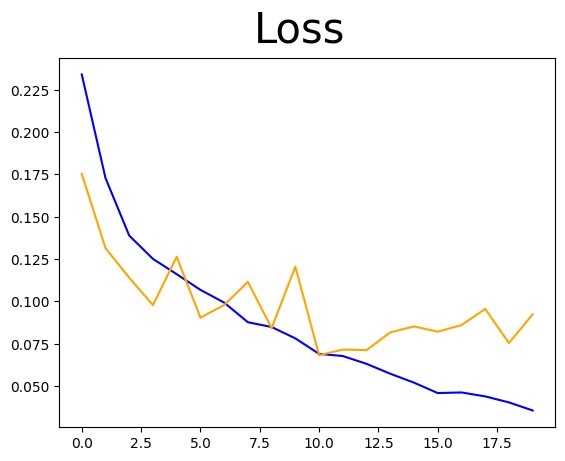

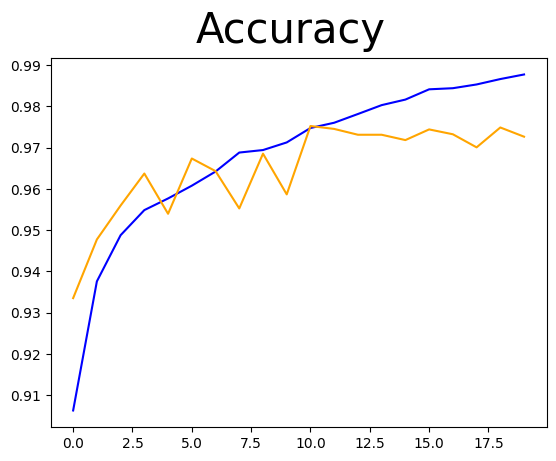

In [38]:
fig = plt.figure()
plt.plot(get_accuracy.history['loss'], color = 'blue', label = 'loss')
plt.plot(get_accuracy.history['val_loss'], color = 'orange', label = 'val_loss')

fig.suptitle('Loss',fontsize = 30)
fig.show()

fig = plt.figure()
plt.plot(get_accuracy.history['accuracy'], color = 'blue', label = 'accuracy')
plt.plot(get_accuracy.history['val_accuracy'], color = 'orange', label = 'val_accuracy')

fig.suptitle('Accuracy',fontsize = 30)
fig.show()        

<font size = "+20"> <b> Model testing </b> </font>

In [3]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
precision = Precision()
recall = Recall()
binaryAccuracy = BinaryAccuracy()
cnt = 0
for batch in test.as_numpy_iterator():
    x,y = batch
    predicted_y = model.predict(x)
    precision.update_state(y,predicted_y)
    recall.update_state(y,predicted_y)
    binaryAccuracy.update_state(y,predicted_y)
    cnt = cnt + 1
    print(cnt)

1/1 [==============================] - 0s 54ms/step
1
1/1 [==============================] - 0s 43ms/step
2
1/1 [==============================] - 0s 44ms/step
3
1/1 [==============================] - 0s 47ms/step
4
1/1 [==============================] - 0s 44ms/step
5
1/1 [==============================] - 0s 51ms/step
6
1/1 [==============================] - 0s 57ms/step
7
1/1 [==============================] - 0s 48ms/step
8
1/1 [==============================] - 0s 44ms/step
9
1/1 [==============================] - 0s 42ms/step
10
1/1 [==============================] - 0s 42ms/step
11
1/1 [==============================] - 0s 42ms/step
12
1/1 [==============================] - 0s 72ms/step
13
1/1 [==============================] - 0s 41ms/step
14
1/1 [==============================] - 0s 87ms/step
15
1/1 [==============================] - 0s 102ms/step
16
1/1 [==============================] - 0s 105ms/step
17
1/1 [==============================] - 0s 113ms/step
18
1/1 [===========

In [41]:
print(f'Precision = {precision.result().numpy()}, Recall = {recall.result().numpy()}, accuracy = {binaryAccuracy.result().numpy()}')

Precision = 0.9843260049819946, Recall = 0.9708480834960938, accuracy = 0.9762910604476929


<font size = "+20"> <b> Performance Evaluation </b> </font>

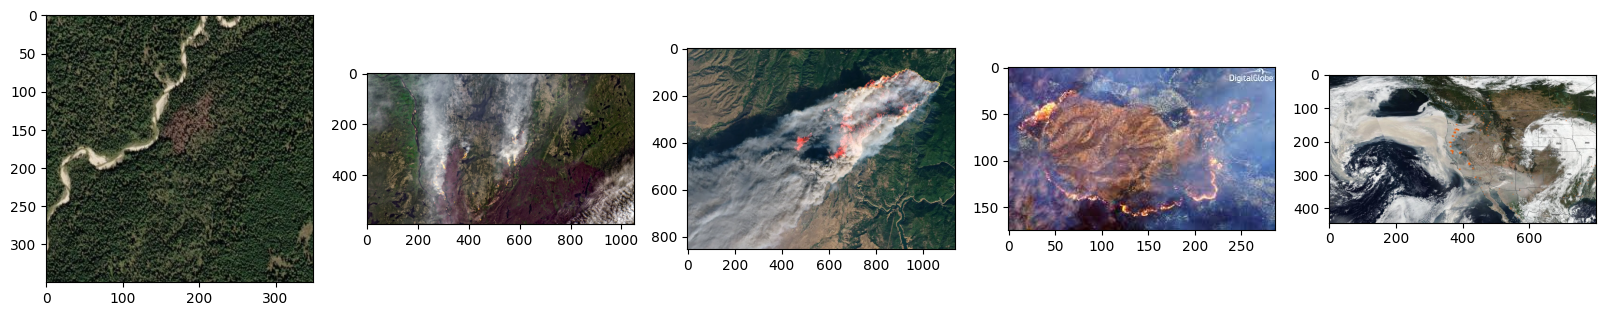

In [23]:
test_images = []
for img in os.listdir('real_data'):
    test_images.append(cv2.imread('real_data\\'+ img))

fig, ax = plt.subplots(ncols = len(test_images), figsize = (20,20))

i = 0
for image in test_images:
    ax[i].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    i = i + 1
    
fig.show()   

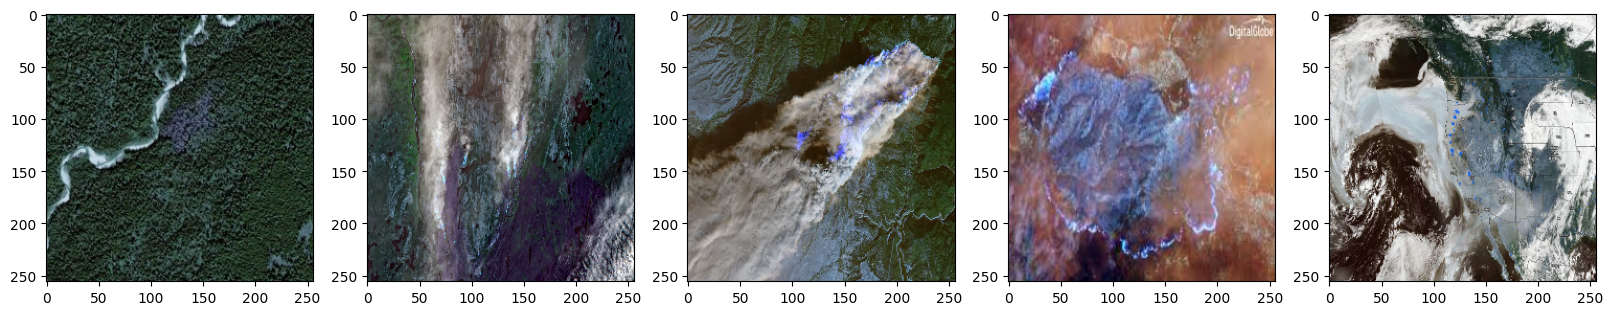

In [24]:
fig, ax = plt.subplots(ncols = len(test_images), figsize = (20,20))

for i in range(0,len(test_images)):
    test_images[i] = tf.image.resize(test_images[i],(256,256))
    ax[i].imshow(test_images[i].numpy().astype(int))
fig.show()  

In [25]:
results = []

for image in test_images:
    predicted_y = model.predict(np.expand_dims(image/255,0))
    results.append(predicted_y)

for result in results:
    print(result)

for result in results:
    if (result >= 0.5): print('wildfire')
    else: print('no wildfire')

1/1 [==============================] - 0s 31ms/step
[[0.99988925]]
[[0.00037992]]
[[0.9999435]]
[[0.0312932]]
[[0.03176291]]
wildfire
no wildfire
wildfire
no wildfire
no wildfire


<font size = "+20"> <b> Saving the model </b> </font>

In [21]:
from tensorflow.keras.models import load_model

In [ ]:
model.save('models\\wildfire_detection_model4.h5')

Ready model to go ^_^

In [22]:
ready_model = load_model('models\\wildfire_detection_model4.h5')